### RQ: Do we notice distinct learning patterns among students? 

#### 0. Preprocessing of AI Usage by student (by count of messages)

In [1]:
# Import the tables of the data set as dataframes.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATA_DIR = "./data" # You many change the directory

# Other main package imports
import seaborn as sns
import scipy as sc

# Scikit-learn package imports
from sklearn import feature_extraction, model_selection
from sklearn.metrics import root_mean_squared_error, mean_squared_error, roc_auc_score

# PyBKT package imports
import random
old_randint = random.randint
random.randint = lambda a, b: old_randint(a, int(b))
from pyBKT.models import Model
random.randint = old_randint



In [2]:
# 1. Map Gymitrainer data to rest of tables 
gymitrainer_df = pd.read_csv(f"{DATA_DIR}/gymitrainer.csv")
gymitrainer_df = gymitrainer_df.drop(columns=['chat_profile'])
#display(gymitrainer_df.head())
mapping_df = pd.read_csv(f"{DATA_DIR}/mapping.csv")
#display(mapping_df.head())

threshold = 0.5
filtered_mapping = mapping_df[mapping_df['confidence'] >= threshold]

# Contains only users where the matching is confident enough and who 
# used the chatbot at all (since they appear in gymitrainer.csv)
# Inner merging guarantees that we only have people who used the chatbot
matched_gymitrainer = pd.merge(
    gymitrainer_df,
    filtered_mapping[['id', 'user_id']],
    on='id',
    how='inner'  
)

In [3]:
tag_replacements = {
    'Mathehilfe': 'Mathe',
    'math_help': 'Mathe',
    'essay_writing': 'Aufsatz',
    'Aufsatzhilfe': 'Aufsatz',
    'Sprachprufung': 'Sprache',
    'text_comprehension': 'Sprache'
}

matched_gymitrainer['tag'] = matched_gymitrainer['tag'].replace(tag_replacements)

def fill_missing_tag(row):
    if pd.isna(row['tag']) or row['tag'] == '':
        content = str(row['content'])
        if content.startswith("['Hallo! Ich bin Gymitrainer, dein Mathe-Tutor") or \
           content.startswith("['Hallo! Mein Name ist Gymitrainer, und ich bin dein Mathe-Guru"):
            return 'Mathe'
        elif content.startswith("['Hey! Ich bin Gymitrainer, dein Experte für Gymi-Prüfungsaufsätze"):
            return 'Aufsatz'
        else:
            return row['tag']
    else:
        return row['tag']

matched_gymitrainer['tag'] = matched_gymitrainer.apply(fill_missing_tag, axis=1)

matched_gymitrainer = matched_gymitrainer.sort_values(by='user_id')
display(matched_gymitrainer.head())   

,Unnamed: 0,id,tag,message_count,startTime,endTime,content,user_id
1630,4454,321dae4e-6d92-40be-b780-232cecf3b586,NaN,1,1730219336,1730219336,['wie soll ich das rechnen'],4
1629,4453,74677c94-340b-4017-9cba-5d38cd1bf581,Aufsatz,3,1730219315,1730220391,"[""Hey! Ich bin Gymitrainer, dein Experte für G...",4
305,772,109cbf59-7ca4-49d7-9879-40d79e666557,Aufsatz,2,1738769310,1738769622,"[""Hey! Ich bin Gymitrainer, dein Experte für G...",6
313,803,bf6c477d-578b-4234-9126-636c64fc09a4,Mathe,3,1738678028,1738681716,"['Hallo! Ich bin Gymitrainer, dein Mathe-Tutor...",6
526,1443,6923b14e-55b3-4aee-8d9c-fd5305295cb2,Mathe,1,1736181505,1736184444,"['Hallo! Ich bin Gymitrainer, dein Mathe-Tutor...",6


In [4]:
# 2. Remove potential teachers from the dataset as a safety 
# (we only want to study learning on students)
teachers = pd.read_csv(f"{DATA_DIR}/teachers.csv")
teacher_ids = teachers['user_id'].unique()
matched_gymitrainer = matched_gymitrainer[~matched_gymitrainer['user_id'].isin(teacher_ids)].copy()

# 3. Clean and prepare the datasets by subjects 
math_results = pd.read_csv(f"{DATA_DIR}/math_results.csv")
math_questions_clean = pd.read_csv(f"{DATA_DIR}/math_questions_clean.csv")
math_results['question'] = math_results['question'].astype(str)
math_questions_clean['question_id'] = math_questions_clean['question_id'].astype(str)
math_results_clean = math_results[
    math_results['question'].isin(math_questions_clean['question_id'])
] 
math_results_clean = math_results_clean.merge(
    math_questions_clean[['question_id', 'skill_id']],
    left_on='question',
    right_on='question_id',
    how='left'
)
math_results_clean = math_results_clean.drop(columns=['question_id'])
math_results_clean['timestamp'] = math_results_clean['time'].astype(int)
math_results_clean['correct'] = math_results_clean['correct'].astype(int)
math_results_clean['hint_used'] = (math_results_clean['hint_count'] > 0).astype(int)

math_data = math_results_clean[['user_id', 'skill_id', 'correct', 'timestamp', 'hint_used']]



In [5]:
# 4. Define AI usage for each user, by subject (a heavy AI user in Essays might not be a heavy AI 
# user in Math, and the criteria shall not be the same as users send many more messages on average
# to Gymitrainer for Math than for other subjects)
subject_tags = ['Mathe', 'Aufsatz', 'Sprache']

ai_usage_per_subject = matched_gymitrainer[matched_gymitrainer['tag'].isin(subject_tags)].groupby(['user_id', 'tag']).size().unstack(fill_value=0)

for subject in subject_tags:
    if subject not in ai_usage_per_subject.columns:
        ai_usage_per_subject[subject] = 0

print("# of Messages for each User, by Subject", ai_usage_per_subject.head())

def compute_threshold(series, percentile=75):
    non_zero = series[series > 0]
    return np.percentile(non_zero, percentile) if len(non_zero) > 0 else 0

def categorize_usage(count, threshold):
    if count == 0:
        return 'non_ai_user'
    elif count <= threshold:
        return 'light_ai_user'
    else:
        return 'heavy_ai_user'

cutoff_percentile = 75

for subject in subject_tags:
    threshold = compute_threshold(ai_usage_per_subject[subject], percentile=cutoff_percentile)
    ai_usage_per_subject[f'{subject}_ai_usage_category'] = ai_usage_per_subject[subject].apply(
        lambda x: categorize_usage(x, threshold)
    )

print("# of Messages for each User, by Subject", ai_usage_per_subject[[f'{s}_ai_usage_category' for s in subject_tags]].head())

# of Messages for each User, by Subject tag      Aufsatz  Mathe  Sprache
user_id                         
4              1      0        0
6              2      7        0
7              0      2        0
9              0      4        0
11             0      3        0
# of Messages for each User, by Subject tag     Mathe_ai_usage_category Aufsatz_ai_usage_category  \
user_id                                                     
4                   non_ai_user             light_ai_user   
6                 heavy_ai_user             light_ai_user   
7                 light_ai_user               non_ai_user   
9                 light_ai_user               non_ai_user   
11                light_ai_user               non_ai_user   

tag     Sprache_ai_usage_category  
user_id                            
4                     non_ai_user  
6                     non_ai_user  
7                     non_ai_user  
9                     non_ai_user  
11                    non_ai_user  


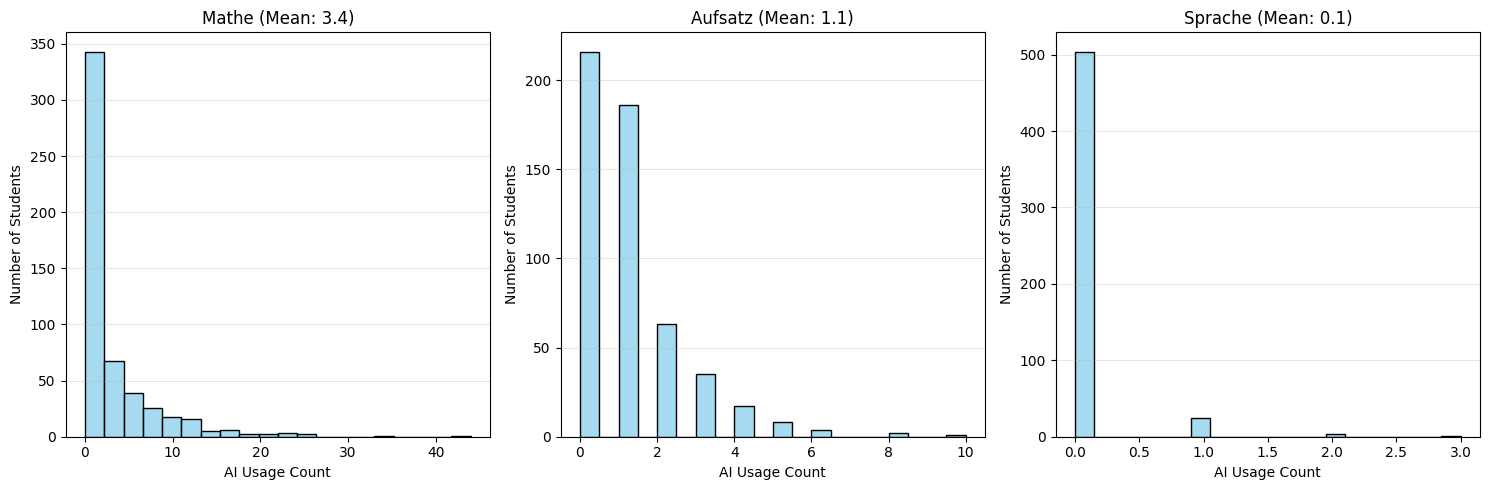

In [6]:
plt.figure(figsize=(15, 5))
for i, subject in enumerate(subject_tags, 1):
    toplot = ai_usage_per_subject[subject]
    if(subject == "Mathe"):
        toplot = ai_usage_per_subject[subject].nsmallest(len(ai_usage_per_subject[subject]) -1 ) #disregard outlier in math
    plt.subplot(1, 3, i)
    sns.histplot(toplot, bins=20, kde=False, color='skyblue')
    plt.title(f'{subject} (Mean: {ai_usage_per_subject[subject].mean():.1f})')
    plt.xlabel('AI Usage Count')
    plt.ylabel('Number of Students')
    plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [7]:
# 5. Create dataframes that contain info on a user's AI usage
math_data_with_ai = math_data.merge(
    ai_usage_per_subject[['Mathe', 'Mathe_ai_usage_category']], 
    on='user_id', 
    how='left'
)

math_data_with_ai['Mathe'] = math_data_with_ai['Mathe'].fillna(0)
math_data_with_ai['Mathe_ai_usage_category'] = math_data_with_ai['Mathe_ai_usage_category'].fillna('non_ai_user')

math_data_categorical = math_data_with_ai.sort_values(
    by=['user_id', 'timestamp'],
    ascending=[True, True]
).reset_index(drop=True)

In [8]:
# 6. Add order_id column that orders a user-id's submissions by skill and time
math_data_categorical['order_id'] = math_data_categorical.groupby('user_id').cumcount() + 1

# 7. Extra columns added to use for AFM/PFA
def preprocess_data(data):
    data = data.copy()  # Avoid modifying a slice of the original DataFrame
    data.loc[:, 'aux'] = 1
    data.loc[:, 'prev_attempts'] = data.sort_values('order_id').groupby(['user_id', 'skill_id'])['aux'].cumsum() - 1

    # Number of correct and incorrect attempts before current attempt
    data.loc[:, 'correct_aux'] = data.sort_values('order_id').groupby(['user_id', 'skill_id'])['correct'].cumsum()
    data.loc[:, 'before_correct_num'] = data.sort_values('order_id').groupby(['user_id', 'skill_id'])['correct_aux'].shift(periods=1, fill_value=0)
    data.loc[:, 'before_wrong_num'] = data['prev_attempts'] - data['before_correct_num']
    return data

math_data_categorical = preprocess_data(math_data_categorical)

# 7. Visualizations

print("Math data example:")
display(math_data_categorical.head(10))

# 8. Datasets cut by AI Usage for training

df_non_ai_math = math_data_categorical[math_data_categorical['Mathe_ai_usage_category'] == 'non_ai_user'].drop(columns='Mathe_ai_usage_category')
df_light_ai_math = math_data_categorical[math_data_categorical['Mathe_ai_usage_category'] == 'light_ai_user'].drop(columns='Mathe_ai_usage_category')
df_heavy_ai_math = math_data_categorical[math_data_categorical['Mathe_ai_usage_category'] == 'heavy_ai_user'].drop(columns='Mathe_ai_usage_category')

display(df_non_ai_math.head(10))

Math data example:


,user_id,skill_id,correct,timestamp,hint_used,Mathe,Mathe_ai_usage_category,order_id,aux,prev_attempts,correct_aux,before_correct_num,before_wrong_num
0,1,Textaufgaben,0,1730512029,0,0.00000,non_ai_user,1,1,0,0,0,0
1,1,Textaufgaben,1,1730512029,0,0.00000,non_ai_user,2,1,1,1,0,1
2,1,Textaufgaben,0,1730512029,0,0.00000,non_ai_user,3,1,2,1,1,1
3,1,Textaufgaben,1,1730512029,0,0.00000,non_ai_user,4,1,3,2,1,2
4,1,Zahlen und Arithmetik,1,1730512029,0,0.00000,non_ai_user,5,1,0,1,0,0
5,1,Zahlen und Arithmetik,1,1730512029,0,0.00000,non_ai_user,6,1,1,2,1,0
6,1,Textaufgaben,0,1730512029,0,0.00000,non_ai_user,7,1,4,2,2,2
7,1,Textaufgaben,1,1730512029,0,0.00000,non_ai_user,8,1,5,3,2,3
8,1,Textaufgaben,1,1730512029,0,0.00000,non_ai_user,9,1,6,4,3,3
9,1,Textaufgaben,0,1730512029,0,0.00000,non_ai_user,10,1,7,4,4,3


,user_id,skill_id,correct,timestamp,hint_used,Mathe,order_id,aux,prev_attempts,correct_aux,before_correct_num,before_wrong_num
0,1,Textaufgaben,0,1730512029,0,0.00000,1,1,0,0,0,0
1,1,Textaufgaben,1,1730512029,0,0.00000,2,1,1,1,0,1
2,1,Textaufgaben,0,1730512029,0,0.00000,3,1,2,1,1,1
3,1,Textaufgaben,1,1730512029,0,0.00000,4,1,3,2,1,2
4,1,Zahlen und Arithmetik,1,1730512029,0,0.00000,5,1,0,1,0,0
5,1,Zahlen und Arithmetik,1,1730512029,0,0.00000,6,1,1,2,1,0
6,1,Textaufgaben,0,1730512029,0,0.00000,7,1,4,2,2,2
7,1,Textaufgaben,1,1730512029,0,0.00000,8,1,5,3,2,3
8,1,Textaufgaben,1,1730512029,0,0.00000,9,1,6,4,3,3
9,1,Textaufgaben,0,1730512029,0,0.00000,10,1,7,4,4,3


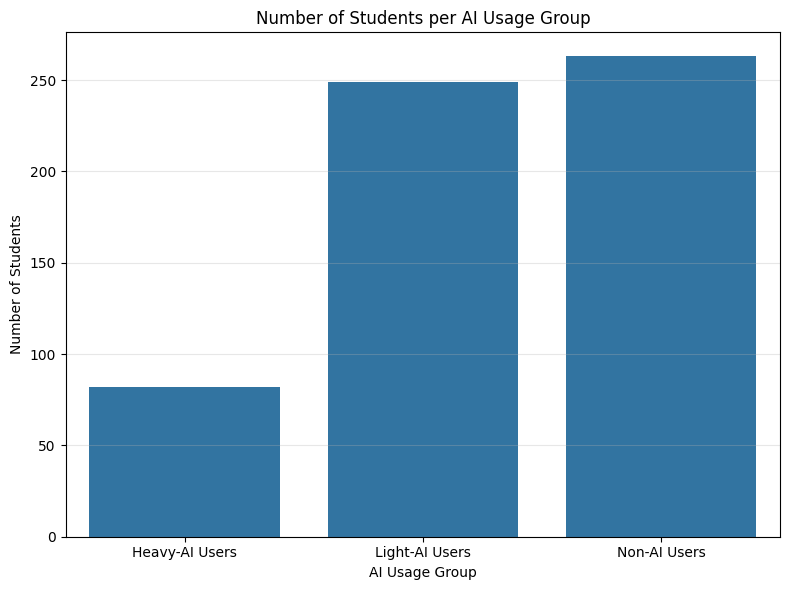

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count unique users in each AI usage category
user_counts = math_data_categorical.groupby('Mathe_ai_usage_category')['user_id'].nunique()

# Optional: Rename index for nicer labels
user_counts.index = user_counts.index.map({
    'non_ai_user': 'Non-AI Users',
    'light_ai_user': 'Light-AI Users',
    'heavy_ai_user': 'Heavy-AI Users'
})

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(x=user_counts.index, y=user_counts.values)
plt.title('Number of Students per AI Usage Group')
plt.xlabel('AI Usage Group')
plt.ylabel('Number of Students')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()


In [10]:
# Load activity data
activity = pd.read_csv(f"{DATA_DIR}/activity.csv")

# 1.1: Student-level aggregation
columns_to_drop = ['Mathe', 'skill_id', 'order_id', 'aux', 'prev_attempts', 'correct_aux', 'before_correct_num', 'before_wrong_num']
math_cleaned = math_data_categorical.drop(columns=columns_to_drop, errors='ignore')

math_summary = math_cleaned.groupby('user_id').agg({
    'correct': ['mean', 'std', 'count'],
    'hint_used': 'mean',
    'Mathe_ai_usage_category': 'first'
})

# Rename columns
math_summary.columns = ['avg_accuracy', 'std_accuracy', 'total_questions', 'hint_usage_rate', 'ai_usage_category']
math_summary = math_summary.reset_index()

# Add activity counts
activity_counts = activity.groupby('user_id').size().rename('activity_count')
math_data_clustering_student = math_summary.merge(activity_counts, on='user_id', how='left').fillna(0)
#display(math_data_clustering_student['ai_usage_category'].head(10))



# 1.2: Student-Skill-level aggregation
columns_to_drop = ['Mathe', 'order_id', 'aux', 'prev_attempts', 'correct_aux', 'before_correct_num', 'before_wrong_num']
math_cleaned_skill = math_data_categorical.drop(columns=columns_to_drop, errors='ignore')

math_skill_summary = math_cleaned_skill.groupby(['user_id', 'skill_id']).agg({
    'correct': ['mean', 'std', 'count'],
    'hint_used': 'mean',
    'Mathe_ai_usage_category': 'first'
})

# Rename columns
math_skill_summary.columns = ['avg_accuracy', 'std_accuracy', 'total_questions', 'hint_usage_rate', 'ai_usage_category']
math_skill_summary = math_skill_summary.reset_index()

# Add activity count (per user only)
activity_counts = activity.groupby('user_id').size().rename('activity_count')
math_data_clustering_studentskill = math_skill_summary.merge(activity_counts, on='user_id', how='left').fillna(0)

# Preview both
#math_data_clustering_student.head(), math_data_clustering_studentskill.head()

print(math_data_clustering_student['ai_usage_category'].value_counts())

ai_usage_category
non_ai_user      263
light_ai_user    249
heavy_ai_user     82
Name: count, dtype: int64


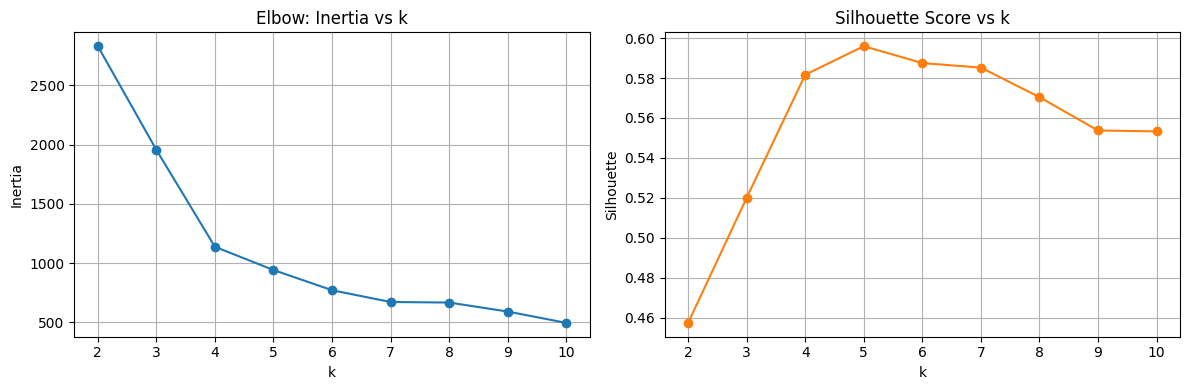

Explained variance ratio (PC1, PC2): [0.52840064 0.20968815]
Optimal k by silhouette: 5


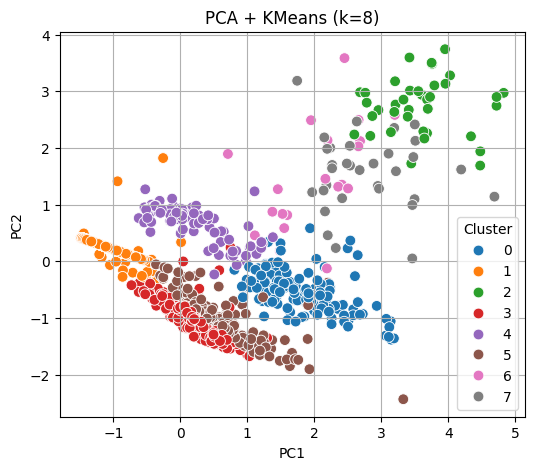

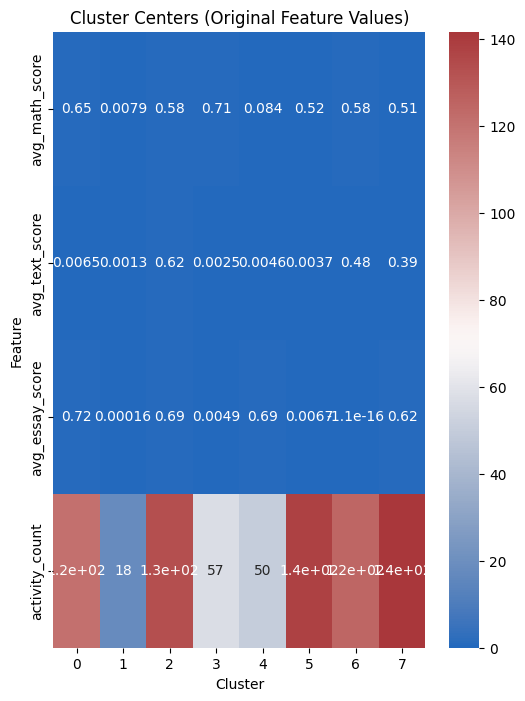

Cluster profiles (mean feature values):
         avg_math_score  avg_text_score  avg_essay_score  activity_count
cluster                                                                 
0               0.64715         0.00649          0.71701       120.89610
1               0.00794         0.00127          0.00016        18.24000
2               0.58389         0.62332          0.68793       133.13514
3               0.71400         0.00252          0.00488        57.27895
4               0.08429         0.00459          0.68547        50.10667
5               0.51729         0.00368          0.00669       138.21374
6               0.58395         0.48249          0.00000       124.70000
7               0.50806         0.39362          0.62311       141.75000
   k  Silhouette Score (↑)  Davies-Bouldin (↓)  Calinski-Harabasz (↑)
0  4               0.62674             0.62218            2,632.97945
1  5               0.64695             0.60853            2,673.63979
2  6               0

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt

# 1. Load tables
students      = pd.read_csv(f"{DATA_DIR}/students.csv")
activity      = pd.read_csv(f"{DATA_DIR}/activity.csv")
math_results  = pd.read_csv(f"{DATA_DIR}/math_results.csv")
text_results  = pd.read_csv(f"{DATA_DIR}/text_results.csv")
essay_results = pd.read_csv(f"{DATA_DIR}/essay_results.csv")

# 2. Aggregate per‐student features
math_avg  = math_results.groupby("user_id")["points"].mean().rename("avg_math_score")
text_results["text_score_ratio"] = text_results["points"] / text_results["max_points"]
text_avg  = text_results.groupby("user_id")["text_score_ratio"].mean().rename("avg_text_score")
grading_columns = [
    "content-on_topic", "content-plausible", "content-convincing_ideas", "content-scope",
    "structure-coherence", "structure-outline", "structure-repetition", "structure-text_pattern",
    "language-clarity", "language-spelling", "language-puncutation",
    "language-word_choice", "language_sentence-structure", "language_style"
]
# essay_results['essay_score'] = essay_results[grading_columns].mean(axis=1)
high_scale = {"content-on_topic",
              "content-convincing_ideas",
              "structure-coherence"}
max_scores = {col: 10 if col in high_scale else 5
              for col in grading_columns}
normed = essay_results[grading_columns].div( # normalize to 0–1
    pd.Series(max_scores)
)
essay_results['essay_score'] = normed.mean(axis=1) # equal‐weight mean on 0–1 scale
essay_avg = essay_results.groupby('user_id')['essay_score'].mean().rename('avg_essay_score')
act_count = activity.groupby("user_id").size().rename("activity_count")

# 3. Build the feature DataFrame
features = (
    pd.concat([math_avg, text_avg, essay_avg, act_count], axis=1)
      .fillna(0)
      .reset_index()
)

# 4. Prepare matrix and scale
X = features.drop(columns=["user_id"])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5. Elbow & Silhouette sweep for k=2…10
Ks, inertias, sil_scores = range(2,11), [], []
for k in Ks:
    km = KMeans(n_clusters=k, random_state=42)
    lbl = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_scaled, lbl))

# 6. Plot diagnostics
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(Ks, inertias, "o-")
plt.title("Elbow: Inertia vs k")
plt.xlabel("k"); plt.ylabel("Inertia"); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(Ks, sil_scores, "o-", color="C1")
plt.title("Silhouette Score vs k")
plt.xlabel("k"); plt.ylabel("Silhouette"); plt.grid(True)
plt.tight_layout()
plt.show()

# 7. PCA to 2D
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print("Explained variance ratio (PC1, PC2):", pca.explained_variance_ratio_)

# 8. Print the k with max silhouette
optimal_k = Ks[sil_scores.index(max(sil_scores))]
print("Optimal k by silhouette:", optimal_k)

# 9. Fit final K-Means
chosen_k = 8
kmeans = KMeans(n_clusters=chosen_k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# 10. Results assembly
results = features.copy()
results["cluster"] = clusters
results["PC1"] = X_pca[:,0]
results["PC2"] = X_pca[:,1]

# 11. PCA scatter with cluster coloring
plt.figure(figsize=(6,5))
sns.scatterplot(data=results, x="PC1", y="PC2", hue="cluster", palette="tab10", s=60)
plt.title(f"PCA + KMeans (k={chosen_k})")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(title="Cluster"); plt.grid(True)
plt.show()

# 12. Heatmap of cluster centers in original features
centers = scaler.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(centers, columns=X.columns).T
plt.figure(figsize=(6,8))
sns.heatmap(centers_df, annot=True, cmap="vlag")
plt.title("Cluster Centers (Original Feature Values)")
plt.ylabel("Feature"); plt.xlabel("Cluster")
plt.show()

# 13. Print cluster profiles
print("Cluster profiles (mean feature values):")
print(results.groupby("cluster")[["avg_math_score","avg_text_score","avg_essay_score","activity_count"]].mean())

# 14. Print clustering evaluation scores 
X_eval = X_pca[:, :7]
k_values = [4, 5, 6, 7, 8]
results = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_eval)
    
    sil = silhouette_score(X_eval, labels)
    db = davies_bouldin_score(X_eval, labels)
    ch = calinski_harabasz_score(X_eval, labels)
    
    results.append({
        "k": k,
        "Silhouette Score (↑)": sil,
        "Davies-Bouldin (↓)": db,
        "Calinski-Harabasz (↑)": ch
    })

results_df = pd.DataFrame(results)
print(results_df)

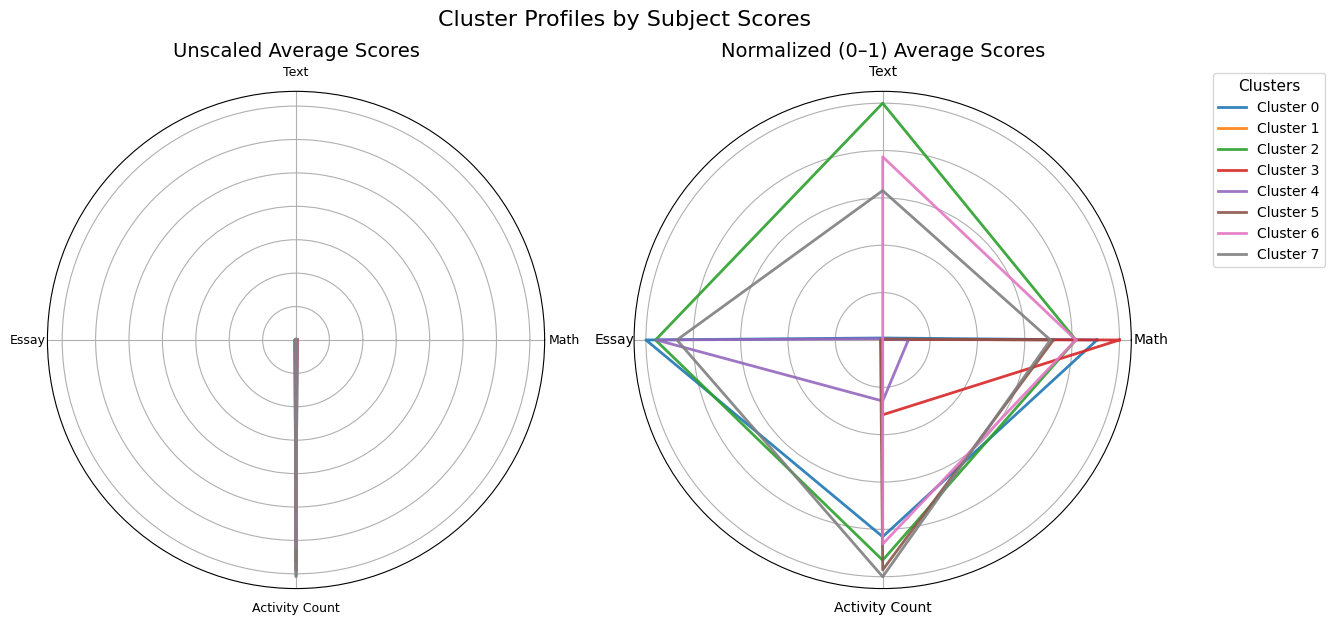

In [33]:
from sklearn.preprocessing import MinMaxScaler

def plot_cluster_subject_profiles(df_clustered, subject_columns, cluster_col="cluster"):
    """
    Creates side-by-side radar plots of cluster-average subject scores,
    both unscaled and normalized.
    """
    # Create readable labels
    def prettify(label):
        return label.replace("avg_", "").replace("_score", "").replace("_", " ").title()
    labels = [prettify(col) for col in subject_columns]
    
    # Compute cluster mean profiles
    profiles = df_clustered.groupby(cluster_col)[subject_columns].mean()
    
    # Normalize for the second plot
    scaler = MinMaxScaler()
    profiles_scaled = pd.DataFrame(
        scaler.fit_transform(profiles),
        columns=profiles.columns,
        index=profiles.index
    )
    
    # Radar setup
    num_vars = len(subject_columns)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]
    colors = plt.cm.tab10.colors
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 7), subplot_kw=dict(polar=True))
    
    # Unscaled plot
    ax = axes[0]
    for idx, (cluster, row) in enumerate(profiles.iterrows()):
        vals = row.tolist() + [row.tolist()[0]]
        ax.plot(angles, vals, color=colors[idx % len(colors)], linestyle='solid', linewidth=2, label=f"Cluster {cluster}", alpha=0.9)
    ax.set_title("Unscaled Average Scores", fontsize=14)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=9)
    ax.set_yticklabels([])
    
    # Normalized plot
    ax = axes[1]
    for idx, (cluster, row) in enumerate(profiles_scaled.iterrows()):
        vals = row.tolist() + [row.tolist()[0]]
        ax.plot(angles, vals, color=colors[idx], linestyle='solid', linewidth=2, label=f"Cluster {cluster}", alpha=0.9)
    ax.set_title("Normalized (0–1) Average Scores", fontsize=14)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=10)
    ax.set_yticklabels([])
    
    plt.suptitle("Cluster Profiles by Subject Scores", size=16, x=0.42)

    axes[1].legend(
         title="Clusters",
         loc='upper left',
         bbox_to_anchor=(1.15, 1.05),
         fontsize=10,
         title_fontsize=11,
         frameon=True
    )

    plt.tight_layout(rect=[0, 0, 0.9, 1.1])
    plt.show()


plot_cluster_subject_profiles(results, ["avg_math_score","avg_text_score","avg_essay_score","activity_count"])

#### 2. Hint-usage for Math Assignments by Cluster 

In [22]:
# 1. Per‐user average hint usage
user_hint_avg = math_results.groupby('user_id')['hint_count']     \
                       .mean()                                 \
                       .rename('avg_hint_usage')

# 2. Merge with your clustering results
#    (results must have columns ['user_id','cluster'])
results_with_hints = results.merge(user_hint_avg, on='user_id', how='left') \
                            .fillna({'avg_hint_usage': 0})

# 3. Compute the mean by cluster
cluster_hint_profile = (
  results_with_hints
    .groupby('cluster')['avg_hint_usage']
    .mean()
    .reset_index 
)

print('Average hint usage by students, by cluster:', cluster_hint_profile, sep="\n")

Average hint usage by students, by cluster:
<bound method Series.reset_index of cluster
0   0.04225
1   0.00177
2   0.05787
3   0.05229
4   0.01381
5   0.05760
6   0.05684
7   0.04791
Name: avg_hint_usage, dtype: float64>


#### Discussion: Hint Request Patterns among Clusters

Our analysis reveals a striking uniformity in the frequency with which students request hints on mathematics problems: across nearly all clusters, the average hint‐per‐question ratio remains approximately 0.05.  Only two cohorts diverge from this pattern—Cluster 1 (the “silent registrations,” characterized by negligible activity and minimal quiz engagement) and Cluster 4 (the “essay‐focused strivers,” who seldom attempt mathematics items).  Crucially, these deviations occur exclusively in groups whose members register almost no math attempts, implying that their lower hint counts reflect lack of participation rather than a pedagogical preference or need.  Therefore, hint usage does not appear to drive the separation of clusters by performance level; instead, it remains a background constant among active math learners, suggesting that other factors—such as prior knowledge, problem‐selection strategies, or motivational dynamics—underlie the observed skill disparities.

In sum, the homogeneity of hint engagement across substantive math‐practicing cohorts indicates that mere access to hints is insufficient to explain differences in student performance.  Future work should explore richer behavioral indicators—response latencies, error‐type sequences, or adaptive problem difficulty—to uncover the latent mechanisms by which learners navigate mathematical challenge.  

#### 3. Classroom Repartition by Cluster

In [23]:
# 1. Merge cluster labels with student group IDs
merged = (
    results[['user_id', 'cluster']]
      .merge(students[['user_id', 'group_id']], on='user_id')
)

# 2. Compute total per cluster for percentages
total_per_cluster = merged.groupby('cluster').size().rename('total_students')

# 3. Count per (group_id, cluster)
counts = merged.groupby(['group_id','cluster']).size().unstack(fill_value=0)

# 4. Compute percentages per cluster
percentages = counts.div(total_per_cluster, axis=1) * 100

# 5. Build formatted cells: "count (pct%)"
formatted = counts.astype(str) + " (" + percentages.round(1).astype(str) + "%)"

# 6. Display the pivoted table with group_id as rows, cluster numbers as columns
print(formatted)

cluster            0           1           2           3          4  \
group_id                                                              
94          4 (2.9%)  24 (19.8%)    0 (0.0%)  22 (13.7%)   1 (2.0%)   
95          1 (0.7%)  16 (13.2%)    0 (0.0%)   10 (6.2%)   2 (4.0%)   
96          2 (1.5%)    1 (0.8%)    0 (0.0%)    8 (5.0%)   0 (0.0%)   
97        15 (11.0%)    0 (0.0%)    1 (2.9%)    1 (0.6%)   1 (2.0%)   
99          1 (0.7%)    1 (0.8%)    0 (0.0%)    6 (3.7%)   0 (0.0%)   
101         0 (0.0%)    0 (0.0%)    0 (0.0%)    0 (0.0%)   0 (0.0%)   
103         7 (5.1%)   12 (9.9%)    0 (0.0%)    5 (3.1%)   4 (8.0%)   
104         0 (0.0%)    3 (2.5%)  15 (42.9%)    3 (1.9%)   0 (0.0%)   
105         5 (3.7%)    1 (0.8%)    0 (0.0%)    5 (3.1%)   2 (4.0%)   
106         3 (2.2%)    0 (0.0%)    0 (0.0%)    4 (2.5%)   0 (0.0%)   
107        10 (7.4%)    0 (0.0%)   5 (14.3%)    0 (0.0%)   0 (0.0%)   
108         5 (3.7%)    0 (0.0%)    0 (0.0%)   12 (7.5%)   0 (0.0%)   
109   

#### Discussion: Classroom Allocation of Learner Clusters

Our analysis indicates that membership in the identified learner clusters is distributed unevenly across classroom groups, with certain classes housing disproportionately high concentrations of specific profiles.  However, the modest size of our dataset and the absence of instructor‐level metadata—such as subject expertise, pedagogical approach, or years of teaching experience—preclude any causal interpretation of these patterns.  Without controlling for classroom assignment policies or teacher characteristics, the observed heterogeneity may simply reflect administrative grouping or random variation rather than meaningful pedagogical effects.

Although the uneven cluster distribution hints at potential classroom or instructor influences on student engagement and performance profiles, the lack of detailed teacher information and the limited sample undermine definitive conclusions.  To elucidate how instructional context shapes learning trajectories, future studies should integrate comprehensive teacher data, expand to larger and more diverse cohorts, and incorporate multilevel modeling to disentangle student‐level and class‐level effects.

#### 4. AI Usage Repartition by Cluster

In [24]:
# 0. Keep one row per user_id in math_data_categorical to compute merged
math_unique = (
    math_data_categorical
      .drop_duplicates(subset='user_id', keep='first')
)

# 1. Merge cluster labels with student group IDs
merged = (
    results[['user_id', 'cluster']]
      .merge(math_unique[['user_id', 'Mathe_ai_usage_category']], on='user_id')
)

# 2. Compute total per cluster for percentages
total_per_cluster = merged.groupby('cluster').size().rename('total_students')

# 3. Count per (Mathe_ai_usage_category, cluster)
counts = merged.groupby(['Mathe_ai_usage_category','cluster']).size().unstack(fill_value=0)

# 4. Compute percentages per cluster
percentages = counts.div(total_per_cluster, axis=1) * 100

# 5. Build formatted cells: "count (pct%)"
formatted = counts.astype(str) + " (" + percentages.round(1).astype(str) + "%)"

# 6. Display the pivoted table with group_id as rows, cluster numbers as columns
print(formatted)

cluster                           0           1           2            3  \
Mathe_ai_usage_category                                                    
heavy_ai_user            24 (15.8%)    0 (0.0%)  11 (29.7%)     6 (3.2%)   
light_ai_user            63 (41.4%)   3 (13.0%)  23 (62.2%)   70 (37.0%)   
non_ai_user              65 (42.8%)  20 (87.0%)    3 (8.1%)  113 (59.8%)   

cluster                           4           5          6           7  
Mathe_ai_usage_category                                                 
heavy_ai_user              0 (0.0%)  26 (21.0%)  5 (25.0%)  10 (32.3%)  
light_ai_user             5 (27.8%)  59 (47.6%)  9 (45.0%)  17 (54.8%)  
non_ai_user              13 (72.2%)  39 (31.5%)  6 (30.0%)   4 (12.9%)  


#### Discussion: AI‐Tutor Engagement Across Clusters

An examination of AI‐tutor utilization reveals substantial heterogeneity across our eight learner cohorts relative to the overall population, in which 13.8\% of users are classified as heavy AI‐tutor consumers, 41.9\% as light users, and 44.3\% as non‐users.  Cluster 0’s distribution of heavy, light, and non‐AI engagement mirrors these aggregate proportions almost exactly; this cluster comprises students whose interactions are narrowly focused on mathematics and essay prompts, suggesting a balanced yet domain‐specific practice pattern.  In contrast, Clusters 1, 3, and 4—denoting silent registrations, essay‐only strivers, and math‐only strivers, respectively—register AI engagement well below the mean.  Their minimal reliance on GymiTrainer implies that these students either possess sufficient intrinsic mastery or underutilize the chatbot’s support, and thus could be guided toward underexplored subjects to broaden their learning horizons.

Conversely, Clusters 2 and 7, each with approximately 30–35 members, feature almost exclusively AI‐engaged users (only 3–4 non‐users per cluster) and correspond to balanced high‐achievers and mixed‐ability generalists.  Their elevated activity volume affords ample opportunity to leverage AI assistance, reinforcing the intuitive link between overall engagement and AI‐tutor usage.  Finally, Clusters 5 and 6 exhibit a modest shift toward heavier AI engagement relative to the global average; these learners log high total activity yet concentrate exclusively on mathematics (Cluster 5) or on both mathematics and language (Cluster 6) without commensurate performance gains.  This pattern of intense but unidimensional interaction suggests a subgroup of students who persist through difficulty but may be over‐relying on help from Gymitrainer rather than consolidating conceptual understanding.

These findings underscore the importance of tailoring AI‐scaffolding and curricular guidance to distinct learner profiles: redirecting proficient “strivers” toward underpracticed domains, calibrating chatbot availability for heavy‐use clusters to foster autonomy, and designing interventions that optimize the interplay between independent problem solving and targeted support.  By aligning pedagogical strategies with the nuanced engagement signatures of each cohort, GoGymi can more effectively shepherd every student along a personalized path to mastery.  
